## GloFAS 
https://www.globalfloods.eu   
https://www.globalfloods.eu/general-information/data-and-services/  

In [186]:
# common import
from datetime import date
import requests, wget
import os, sys,json
import numpy as np
import math
import geopandas
from IPython.display import Image, HTML

### WMS Service  
http://globalfloods-ows.ecmwf.int/glofas-ows/ows.py?  
http://www.globalfloods.eu/static/downloads/GloFAS-WMS-T_usermanual.pdf   

In [38]:
# import leaflet
from ipyleaflet import Map,WMSLayer,basemaps,WidgetControl,GeoJSON
# import owslib
from owslib.wms import WebMapService

In [160]:
# load basic information of WMS service
wms_url = 'http://globalfloods-ows.ecmwf.int/glofas-ows/ows.py?'
wms = WebMapService(wms_url)
print(wms.identification.title)
print([operation.name for operation in wms.operations])
layers=list(wms.contents)
print(layers)

GLOFAS OWS
['GetCapabilities', 'GetMap', 'GetFeatureInfo', 'DescribeLayer', 'GetLegendGraphic', 'GetStyles']
['GLOFAS_OWS', 'Static', 'date', 'FloodHazard100y', 'MajorRiverBasins', 'GlofasLakesReservoirs', 'GlofasReservoirImpact', 'UpstreamArea', 'MajorRivers1', 'MajorRivers2', 'MajorRivers3', 'MajorRivers4', 'MajorRivers5', 'MajorRivers6', 'AdministrativeRegions', 'ErrorMessage', 'Hydrological', 'RPG_U', 'RPGM', 'RPGH', 'RPGS', 'sumALHEGE', 'sumALEEGE', 'RPG80', 'rivermap_4mon', 'areamap_4mon', 'sumAL41EGE', 'sumAL42EGE', 'sumAL43EGE', 'Meteorological', 'EGE_probRgt300', 'EGE_probRgt150', 'EGE_probRgt50', 'AccRainEGE', 'RainAnimation', 'Flood risk', 'RapidImpactAssessment', 'RapidFloodMapping']


In [161]:
# info on RPG_U
layer = "RPG_U"
print(wms[layer].title)
print(wms[layer].boundingBox)
print(wms[layer].boundingBoxWGS84)
print(wms[layer].styles)

Reporting Points
(-20037500.0, -20049000.0, 20037500.0, 20049000.0, 'EPSG:3857')
(-180.0, -85.06, 180.0, 85.06)
{'default': {'title': 'default', 'legend': 'http://globalfloods-ows.ecmwf.int/glofas-ows/?version=1.1.1&service=WMS&request=GetLegendGraphic&layer=RPG_U&format=image/png&STYLE=default'}}


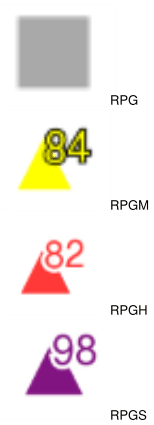

In [162]:
# load legend
legend_url = wms[layer].styles['default']['legend']
legend_image=Image(legend_url,format='png',height=100)
display(legend_image)

In [76]:
# select a testing aqid = 2813
# use geopandas
watersheds_gdb = 'WRIWatersheds.gdb'
watersheds = geopandas.read_file(watersheds_gdb)
watersheds.set_index("aqid",inplace=True)

In [163]:
test_aqid = 2813
# get the image 
x1,y1,x2,y2 = watersheds.loc[[test_aqid],'geometry'].total_bounds
wms_img = wms.getmap(layers=[layer], styles=["default"], srs='EPSG:4326',bbox=[x1,y1,x2,y2],size=(400, 300),format='image/png', transparent=True)

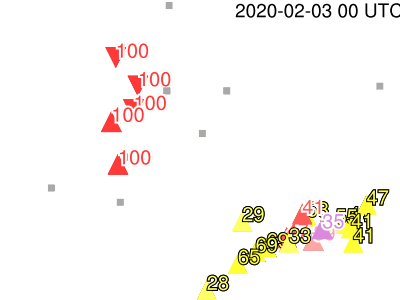

In [164]:
Image(wms_img.read())

In [165]:
# example watersheds on leaflet map
test_json = json.loads(geopandas.GeoSeries([watersheds.loc[test_aqid,'geometry']]).to_json())

# Reporting Points: EPSG 3857
wms_layer = 'RPG_U'
m = Map(center=((y1+y2)/2,(x1+x2)/2), zoom=5,basemap=basemaps.Esri.WorldTopoMap)
wms1 = WMSLayer(
    url=wms_url,
    layers=wms_layer,
    transparent=True,
    format="image/png",
    version="1.3.0",
)
m.add_layer(wms1)
poly_json = GeoJSON(data=test_json['features'][0])
m.add_layer(poly_json)
m

Map(basemap={'url': 'http://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/tile/{z}/{y}…

In [188]:
# work wms getfratureinfo example
wms_paras = {
    'SERVICE':'WMS',
    'REQUEST':'GetFeatureInfo',
    'FORMAT':'image/png',
    'VERSION':'1.3.0',
    'LAYERS':'RPG_U',
    'WIDTH':1020,
    'HEIGHT':678,
    'CRS':'EPSG:3857',
    'BBOX':'-13094904.603227489,2941622.234325256,-8105095.39677251,6258377.765674742',
    'INFO_FORMAT':'text/html',
    'QUERY_LAYERS':'RPG_U',
    'I':456,
    'J':227
}
resp = requests.get(wms_url, params=wms_paras)

In [189]:
HTML(resp.text)

In [190]:
# nore feature example
wms_paras['I']=100
wms_paras['J']=100
resp1 = requests.get(wms_url, params=wms_paras)
resp1.text

'No feature selected'